In [1]:
import pandas as pd
import numpy as np

import os

import pathlib

import requests

import scipy

import statsmodels.api as sm
import matplotlib.pyplot as plt

import matplotlib as mpl

%matplotlib inline

from pylab import rcParams
rcParams['figure.figsize'] = 12, 10
rcParams['pdf.fonttype'] = 42
inline_rc = dict(plt.rcParams)

import platform
import sys

import geopandas as gpd


In [2]:
print("Operating System " + platform.system() + " " + platform.release())
print("Python Version " + str(sys.version))
print("Pandas Version " + str(pd.__version__))
print("Numpy Version " + str(np.__version__))
print("Matplotlib Version " + str(mpl.__version__))
#print("Well Application Version " + str(wa.__version__))
print("Scipy Version " +str(scipy.__version__))
print (os.environ['CONDA_DEFAULT_ENV'])

Operating System Windows 10
Python Version 3.11.8 | packaged by conda-forge | (main, Feb 16 2024, 20:40:50) [MSC v.1937 64 bit (AMD64)]
Pandas Version 2.2.2
Numpy Version 1.26.4
Matplotlib Version 3.8.4
Scipy Version 1.13.0
pygis311v4


In [3]:
main_path = pathlib.Path("G:/Shared Drives/UGS_Groundwater/Projects/Pahvant_Valley/")
figure_dir = main_path / "Writing" / "Figures" / "GEE_out"
raw_dir = main_path / "Pahvant_Basins" / 'Pahvant_Basins6'
parquet_dir = raw_dir / "parquet"
save_place = main_path / "Pahvant_Basins" / "GEE_out" / "byhydrodiv"
gis_path = main_path / "GIS_Pahvant"
#G:\Shared drives\UGS_Groundwater\Projects\Pahvant_Valley\Pahvant_Basins\GEE_out
#save_place = "GEE_Summary_Out"

spr_data = main_path / "Python" / "DailyValues2022163816.csv"
climate_dir = main_path / "Climate_Station_Data"
pumpdata = main_path / "Groundwater_Pumping" / "Groundwater_Conditions_In_Utah.xlsx"


In [10]:
pmlmo = pd.read_parquet(save_place / "pml_mo.parquet")
terra_mo = pd.read_parquet(save_place / "terra_mo_hydrodiv.parquet")
terra_mo = terra_mo.reset_index().groupby(['hucname','date']).mean()
daymetmo = pd.read_parquet(save_place / "daymet_mo_hydrodiv.parquet")
oet_sorted = pd.read_parquet(save_place / "openet_hydrodiv.parquet")
gpm_sorted = pd.read_parquet(save_place / "gpm_monthly_hydrodiv.parquet")
prism_abb = pd.read_parquet(save_place / "prism_mo_hydrodiv.parquet")
smap_abb = pd.read_parquet(save_place / "smap_mo_hydrodiv.parquet")
modis_abb = pd.read_parquet(save_place / "modis_mo.parquet")
modis_abb.index = modis_abb.index.rename('hucname',level=0)

spring_flow_cy = pd.read_parquet(main_path / "Flow Monitoring/clear_lake_spring_flow_cy.parquet")
spring_avg_Q_m = pd.read_parquet(main_path / "Flow Monitoring/clear_lake_spring_flow_mo.parquet")
spring_raw_flow = pd.read_parquet(main_path / "Flow Monitoring/clear_lake_spring_flow_raw.parquet")

swbwy = pd.read_parquet(save_place / "pahvant_basin_summary_monthly.parquet")
swbwy.index = swbwy.index.rename(['hucname', 'date'])
for col in swbwy.columns:
    swbwy = swbwy.rename(columns={col: f"swb_{col}"})

swbmo = pd.read_parquet(save_place / "pahvant_basin_summary_monthly_data.parquet")
swbmo.index = swbmo.index.rename(['hucname', 'date'])
for col in swbmo.columns:
    swbmo = swbmo.rename(columns={col: f"swb_{col}"})

priswy = pd.read_parquet(save_place / "prism_wy.parquet")

ssebp_abb = pd.read_csv(save_place / 'ssebop_mo.csv',  parse_dates=True,
                        index_col=['hucname','date']).sort_index()

compiled = pd.concat([pmlmo, modis_abb, swbmo, terra_mo, daymetmo, oet_sorted['openet_aet_acft'], gpm_sorted['gpm_ppt_acft'], prism_abb,
                      smap_abb,ssebp_abb['ssebop_aet']],sort=True,axis=1)

for col in compiled.columns:
    if 'acft' in col:
        new_col = col[:-5]
    else:
        new_col = col

    if col == 'SubsurfaceSM':
        new_col = 'smap_soil'
    #print(new_col)
    compiled = compiled.rename(columns={col:new_col})
    


C:\Users\paulinkenbrandt\AppData\Local\Temp\1\ipykernel_23372\1268992543.py:28: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ssebp_abb = pd.read_csv(save_place / 'ssebop_mo.csv',  parse_dates=True,


In [11]:
hydrodivs = gpd.read_file(gis_path / 'Valley_Hydrogeologic_Divisions.shp')
combined = pd.merge(hydrodivs, compiled.reset_index(), left_on='ID', right_on='hucname').set_index(['ID','date'])

In [12]:
combined['Bdrk_v_Val'].unique()

array(['Valley', 'Bdrk', 'Basalt'], dtype=object)

In [13]:
bv_area = combined[combined['Bdrk_v_Val'].isin(['Basalt','Valley'])].groupby(level=0).mean(numeric_only=True)['Shape_Area'].sum()*0.000247105
print(f"Basalt and Valley Fill covers {bv_area:0.0f} acres")

Basalt and Valley Fill covers 699157 acres


In [14]:
v_area = np.sum(hydrodivs[(hydrodivs['Bdrk_v_Val']=='Valley')&(~hydrodivs['WRarea'].isin(['West Desert','Oasis','Clear Lake']))].geometry.area)*0.000247105
print(f"Valley Fill covers {v_area:0.0f} acres")

Valley Fill covers 273581 acres


## Corn Creek Comparison

In [19]:
corn

,cfs,cfd,water year
datetime,,,
1965-08-01,29.0,2505600.0,1965
1965-08-02,15.0,1296000.0,1965
1965-08-03,11.0,950400.0,1965
1965-08-04,10.0,864000.0,1965
1965-08-05,10.0,864000.0,1965
...,...,...,...
1975-09-25,8.1,699840.0,1975
1975-09-26,8.1,699840.0,1975
1975-09-27,8.1,699840.0,1975


In [20]:
url = "https://waterdata.usgs.gov/nwis/dv?cb_00060=on&format=rdb&site_no=10233500&legacy=&referred_module=sw&period=&begin_date=1965-08-01&end_date=1975-09-29"
corn = pd.read_table(url,comment="#")
corn = corn.drop([0],axis=0)
corn['datetime'] = pd.to_datetime(corn['datetime'])
corn = corn.rename(columns = {'143840_00060_00003':'cfs'})
corn['cfs'] = pd.to_numeric(corn['cfs'])
corn['cfd'] = 86400*corn['cfs']
corn = corn.drop(['agency_cd','143840_00060_00003_cd','site_no'],axis=1)
corn = corn.set_index('datetime')

corn = corn.interpolate()
corn['water year'] = corn.index.shift(-9, freq='ME').year+1

cornwy = corn.loc['1965-10-01':].groupby('water year').sum()
cornyr = corn.loc['1966-01-01':].groupby(corn.loc['1966-01-01':].index.year).sum()
cornwy['ac-ft'] = cornwy['cfd']*2.29569e-5
cornyr['ac-ft'] = cornyr['cfd']*2.29569e-5
print(f"Avg {cornwy['ac-ft'].mean():0.0f} acft per water year")
print(f"Avg {cornyr['ac-ft'].mean():0.0f} acft per year")

#43

corn_w_ppt_wy = pd.concat([priswy.loc[43],cornwy.drop(['cfs','cfd'],axis=1)],axis=1).dropna()



x = corn_w_ppt_wy['prism_ppt_volume_af'].values
y = corn_w_ppt_wy['ac-ft'].values

X = sm.add_constant(x)
model = sm.OLS(y, X)
results = model.fit()

results.summary()


Avg 12877 acft per water year
Avg 12755 acft per year


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v4\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  res = hypotest_fun_out(*samples, **kwds)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.271
Model:                            OLS   Adj. R-squared:                  0.179
Method:                 Least Squares   F-statistic:                     2.967
Date:                Mon, 13 May 2024   Prob (F-statistic):              0.123
Time:                        11:26:08   Log-Likelihood:                -100.17
No. Observations:                  10   AIC:                             204.3
Df Residuals:                       8   BIC:                             205.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -4637.8154   1.03e+04     -0.448      0.666   -2.85e+04    1.92e+04
x1             0.1669      0.097      1.722      0.123      -0.057       0.390
==============================================================================
Omnibus:                        0.900   Durbin-Watson:                   1.598
Prob(Omnibus):                  0.638   Jarque-Bera (JB):                0.060
Skew:                          -0.190   Prob(JB):                        0.970
Kurtosis:                       3.015   Cond. No.                     5.76e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.76e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

SWB Avg 2166 acft/wy
TerraClimate Avg 5227 acft/wy
Corn Avg 12877 acft/wy


<Axes: xlabel='wateryear'>

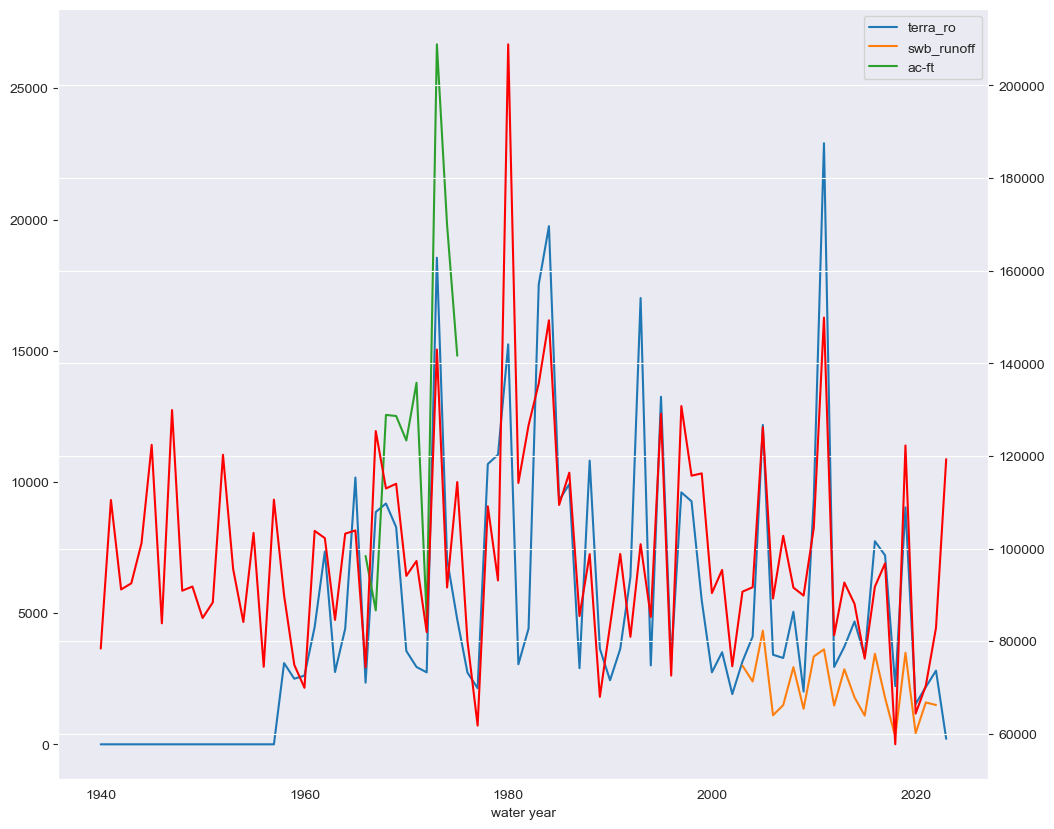

In [21]:
combined['water year'] = combined.index.get_level_values(1).shift(-9, freq='ME').year+1
combined.loc[43].groupby('water year').sum(numeric_only=True).loc[:,'terra_ro'].plot() #corn
swbwy.loc[43,'swb_runoff'].plot()
print(f"SWB Avg {swbwy.loc[43,'swb_runoff'].mean():0.0f} acft/wy")
print(f"TerraClimate Avg {combined.loc[43].groupby('water year').sum(numeric_only=True).loc[2002:,'terra_ro'].mean():0.0f} acft/wy")

print(f"Corn Avg {cornwy['ac-ft'].mean():0.0f} acft/wy")

cornwy['ac-ft'].plot()
plt.legend()
plt.grid()
ax2 = plt.twinx()
priswy.loc[43,"prism_ppt_volume_af"].plot(ax=ax2,color='red')
#plt.grid()

## Chalk Creek Comparison

In [23]:
url = "https://waterdata.usgs.gov/nwis/dv?cb_00060=on&format=rdb&site_no=10232500&legacy=&referred_module=sw&period=&begin_date=1944-03-01&end_date=1971-09-29"

chalk = pd.read_table(url,comment="#")
chalk = chalk.drop([0],axis=0)
chalk['datetime'] = pd.to_datetime(chalk['datetime'])
chalk = chalk.rename(columns = {'143838_00060_00003':'cfs'})
chalk['cfs'] = pd.to_numeric(chalk['cfs'])
chalk['cfd'] = 86400*chalk['cfs']
chalk = chalk.drop(['agency_cd','143838_00060_00003_cd','site_no'],axis=1)
chalk = chalk.set_index('datetime')

chalk = chalk.resample('1D').asfreq().interpolate(method='time')
chalk['water year'] = chalk.index.shift(-9, freq='ME').year+1
chalkwy = chalk.groupby('water year').sum()
chalkwy['ac-ft'] = chalkwy['cfd']*2.29569e-5
chalkwy = chalkwy.loc[1945:]
#27

chalk_w_ppt_wy = pd.concat([priswy.loc[27],chalkwy.drop(['cfs','cfd'],axis=1)],axis=1).dropna()

x = chalk_w_ppt_wy['prism_ppt_volume_af'].values
y = chalk_w_ppt_wy['ac-ft'].values

X = sm.add_constant(x)
model = sm.OLS(y, X)
results = model.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.407
Model:                            OLS   Adj. R-squared:                  0.383
Method:                 Least Squares   F-statistic:                     17.16
Date:                Mon, 13 May 2024   Prob (F-statistic):           0.000343
Time:                        11:27:06   Log-Likelihood:                -276.08
No. Observations:                  27   AIC:                             556.2
Df Residuals:                      25   BIC:                             558.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.378e+04   8732.095     -1.578      0.127   -3.18e+04    4207.331
x1             0.4371      0.106      4.142      0.000       0.220       0.654
==============================================================================
Omnibus:                        0.416   Durbin-Watson:                   1.934
Prob(Omnibus):                  0.812   Jarque-Bera (JB):                0.434
Skew:                          -0.258   Prob(JB):                        0.805
Kurtosis:                       2.655   Cond. No.                     5.41e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.41e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<Axes: xlabel='datetime'>

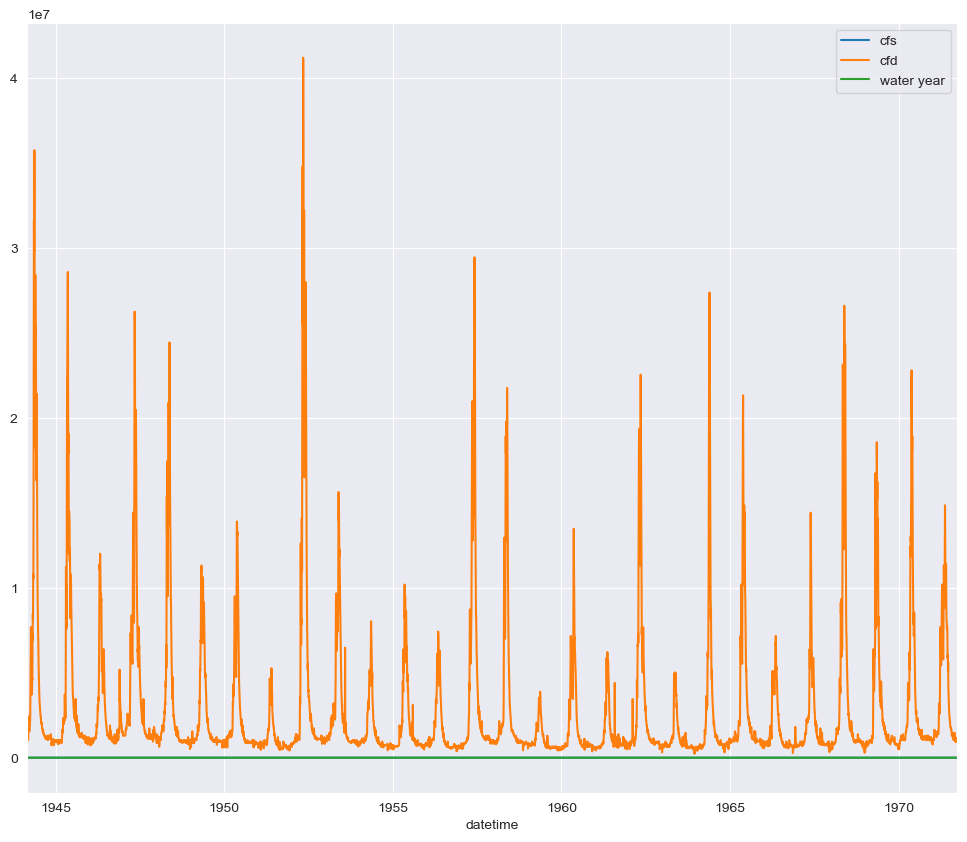

In [24]:
chalk.plot()

SWB Avg 1631 acft/wy
TerraClimate Avg 5593 acft/wy
Chalk Avg 21969 acft/wy


Text(0, 0.5, 'PRISM Precip for Chalk Watershed (ac-ft/yr)')

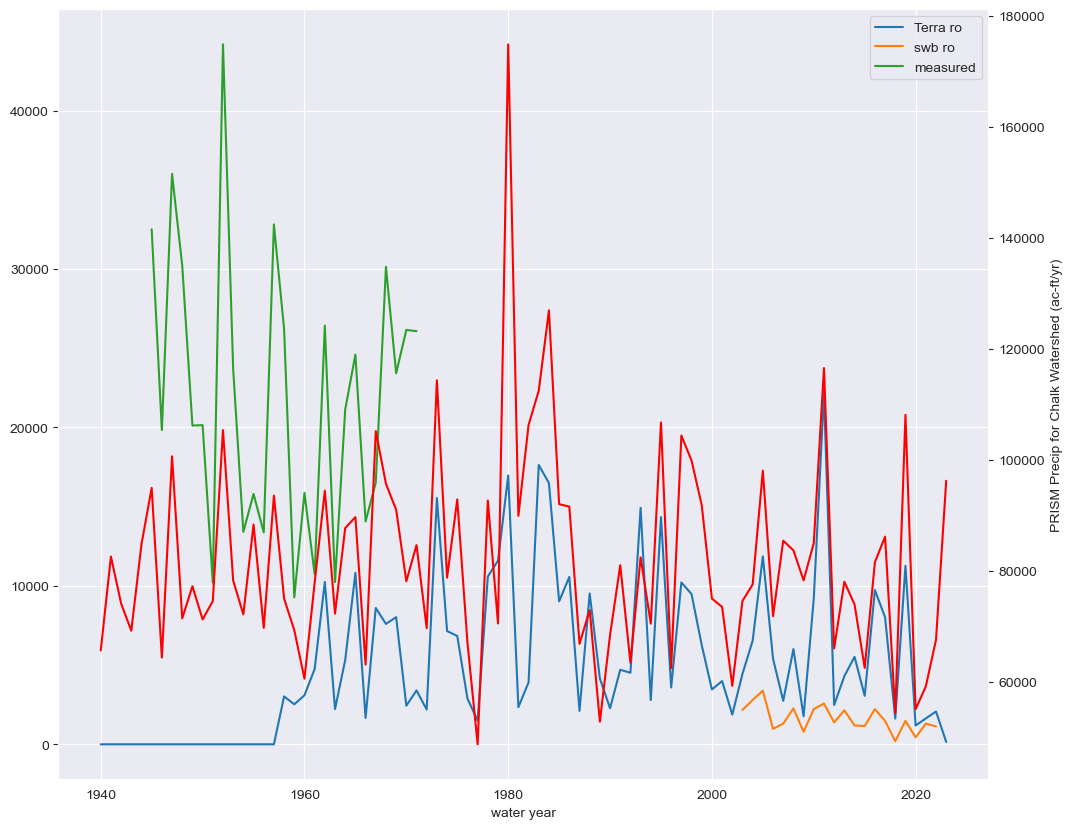

In [26]:
combined['water year'] = combined.index.get_level_values(1).shift(-9, freq='ME').year+1
combined.loc[27].groupby('water year').sum(numeric_only=True).loc[:,'terra_ro'].plot(label='Terra ro') #corn
swbwy.loc[27,'swb_runoff'].plot(label='swb ro')
print(f"SWB Avg {swbwy.loc[27,'swb_runoff'].mean():0.0f} acft/wy")
print(f"TerraClimate Avg {combined.loc[27].groupby('water year').sum(numeric_only=True).loc[2002:,'terra_ro'].mean():0.0f} acft/wy")
chalkwy['ac-ft'].plot(label='measured')
print(f"Chalk Avg {chalkwy['ac-ft'].mean():0.0f} acft/wy")
plt.legend()
ax2 = plt.twinx()
priswy.loc[27,"prism_ppt_volume_af"].plot(ax=ax2,color='red')
plt.grid()
plt.ylabel('PRISM Precip for Chalk Watershed (ac-ft/yr)')


In [28]:
url = "https://nwis.waterservices.usgs.gov/nwis/iv/?sites=10232000&parameterCd=00065&startDT=2022-10-01T00:00:00-07:00&endDT=2023-10-01T00:00:00-07:00&siteStatus=all&format=rdb"
schalk = pd.read_table(url,comment="#")
schalk = schalk.drop([0],axis=0)
schalk['datetime'] = pd.to_datetime(schalk['datetime'])
schalk = schalk.rename(columns = {'316832_00065':'stage'})
schalk['stage'] = pd.to_numeric(schalk['stage'])
schalk['depth'] = schalk['stage'] - 2.0
schalk['cfs'] = (1.486/0.012)*((12*schalk['depth'])**(2/3))*(0.01023**(0.5))
schalk['cfd'] = 86400*schalk['cfs']
schalk = schalk.drop(['agency_cd','316832_00065_cd','tz_cd'],axis=1)
#schalk = schalk.set_index('datetime')

schalk = schalk.drop_duplicates(subset='datetime').set_index('datetime')

schalk_min = schalk.drop(['site_no'],axis=1).resample('1min').asfreq().interpolate(method='time')
schalk_min['cfm'] = schalk_min['cfs']*60.0
schalk_min['acft'] = schalk_min['cfm']*2.29569e-5
schalk_min['water year'] = schalk_min.index.shift(-9, freq='ME').year+1
schalkwy = schalk_min.groupby('water year').sum()

schalk_hr = schalk.resample('1h').mean(numeric_only=True)
schalk_day = schalk.resample('1D').median(numeric_only=True)

schalk_day

,stage,depth,cfs,cfd
datetime,,,,
2022-10-01,2.10,0.10,14.143695,1.222015e+06
2022-10-02,2.10,0.10,14.143695,1.222015e+06
2022-10-03,2.11,0.11,15.071553,1.302182e+06
2022-10-04,2.11,0.11,15.071553,1.302182e+06
2022-10-05,2.12,0.12,15.971672,1.379952e+06
...,...,...,...,...
2023-09-27,2.14,0.14,17.700338,1.529309e+06
2023-09-28,2.14,0.14,17.700338,1.529309e+06
2023-09-29,2.14,0.14,17.700338,1.529309e+06


## SNOTEL Comparison

<Axes: xlabel='wateryear'>

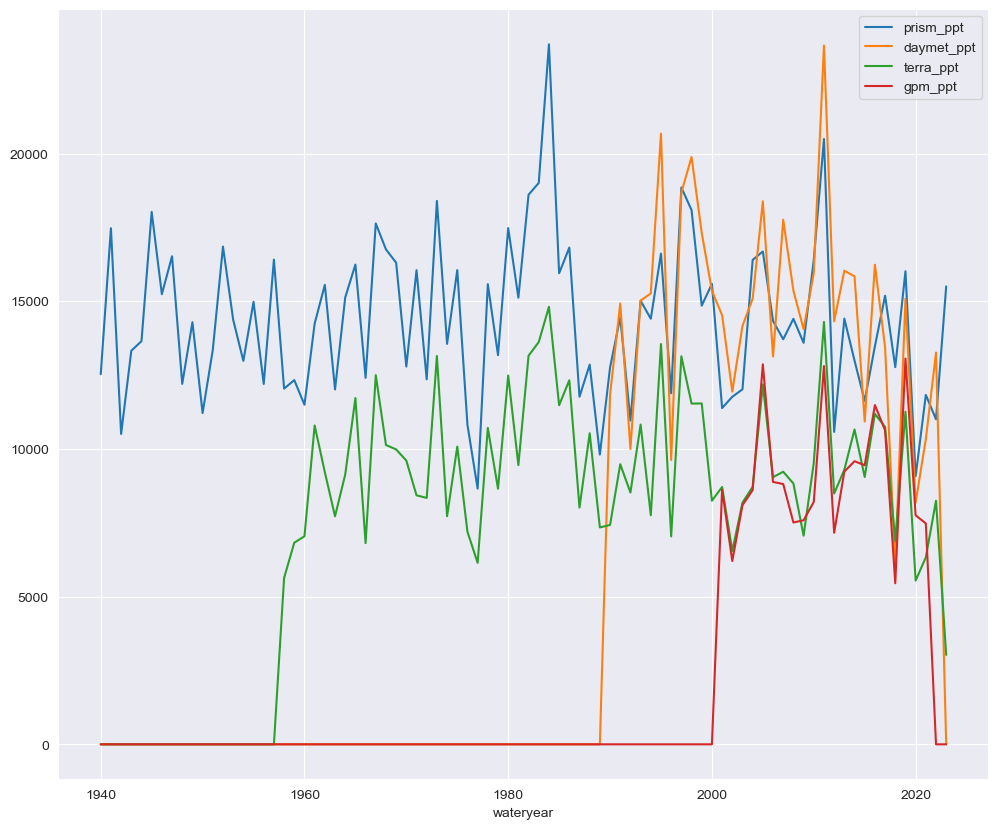

In [30]:
#,'SubsurfaceSM', 'SurfaceSM','daymet_swe'
comb_pine = combined.loc[52,['prism_ppt','daymet_ppt','terra_ppt','gpm_ppt']]
comb_pine['wateryear'] = comb_pine.index.shift(-9, freq='ME').year+1
comb_pine_wy = comb_pine.groupby('wateryear').sum()
comb_pine_wy.plot()

KeyError: 'area_acres'

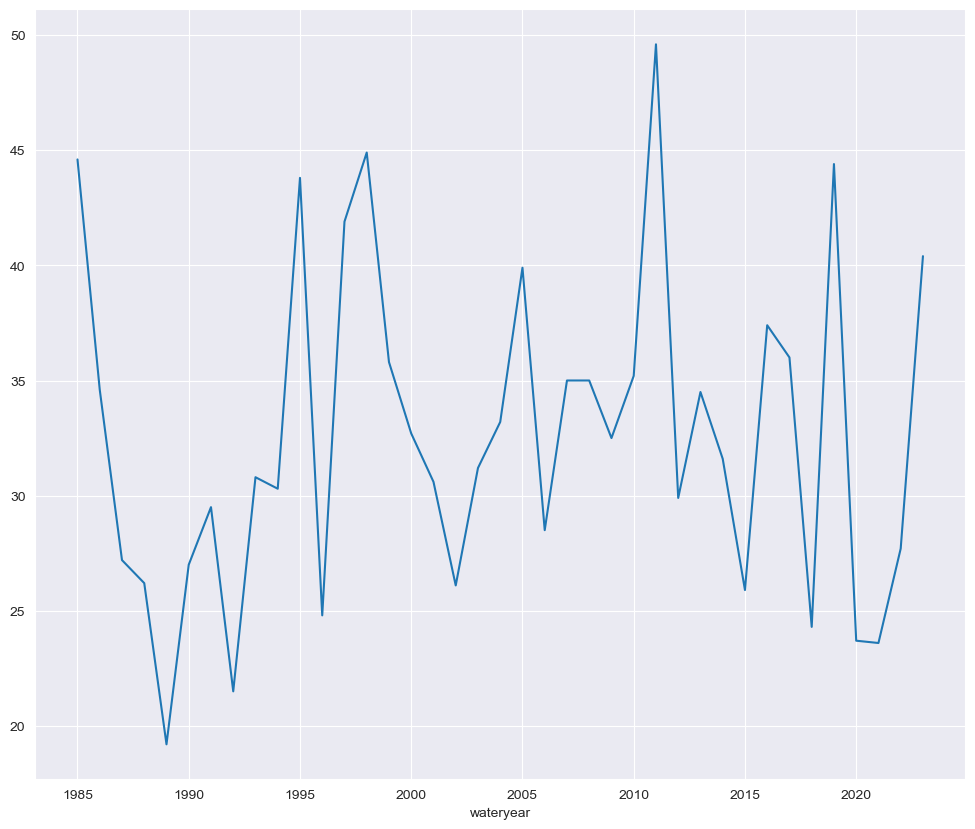

In [31]:
snotel_url = "https://wcc.sc.egov.usda.gov/reportGenerator/view_csv/customSingleStationReport/daily/694:UT:SNTL%7Cid=%22%22%7Cname/POR_BEGIN,POR_END/WTEQ::value,PREC::value,TMAX::value,TMIN::value,TAVG::value,PRCP::value"
snotel = pd.read_csv(snotel_url,comment="#",na_values=-99.0,parse_dates=True,index_col='Date')
snotel['wateryear'] = snotel.index.shift(-9, freq='ME').year+1
snotel = snotel[snotel['wateryear']<2024]
snotel_wy = snotel.groupby('wateryear').max()
snotel_wy['Precipitation Accumulation (in) Start of Day Values'].plot()

pine_area = hydrodivs[(hydrodivs['Watershed'] == 'Pine Creek')&(hydrodivs['Bdrk_v_Val'] == 'Bdrk')]['area_acres'].values
snotel_vol = snotel_wy['Precipitation Accumulation (in) Start of Day Values']/12*pine_area
#snotel_vol.plot()
plt.grid()
#'Precipitation Accumulation (in) Start of Day Values']

## Combine by large regions

In [32]:
area_groups = {'east mountains':[67,11,60,21,22,55,27,52,51,43,77,47],
               'east valley':[7,14,57,26,33,3],
               'basalt':[118,23,120],
               'west mountains':[116],
               'west flats':[20,4,2],
               'NW Spring Flats':[5,13,10,12]}
int_areas = {}

for k, v in area_groups.items():
    for item in v:
        int_areas[item] = k


swbwy['area group'] = swbwy.index.get_level_values(0).map(int_areas)

swb_wy = swbwy.groupby(['area group','date']).sum()



In [34]:
combined['area group'] = combined.index.get_level_values(0).map(int_areas)
comb_areas = combined.reset_index().groupby(['area group','date']).sum(numeric_only=True)

comb_areas['water year'] = comb_areas.index.get_level_values(1).shift(-9, freq='ME').year+1
comb_areas['year'] = comb_areas.index.get_level_values(1).year
comb_areas_yr = comb_areas.groupby(['area group','year']).sum()
comb_areas_yr = comb_areas_yr[(comb_areas_yr.index.get_level_values(1) >= 2000)&(comb_areas_yr.index.get_level_values(1) <= 2022)]
comb_areas_wy = comb_areas.groupby(['area group','water year']).sum()
comb_areas_wy = comb_areas_wy[(comb_areas_wy.index.get_level_values(1) >= 2000)&(comb_areas_wy.index.get_level_values(1) <= 2022)].replace(0,np.nan)

all_yr = comb_areas_yr.groupby(level=1).sum()
all_wy = comb_areas_wy.groupby(level=1).sum()

In [ ]:
comb_areas.to_parquet("C:/Users/paulinkenbrandt/Documents/ArcGIS/Projects/Pahvant/combined_hydro_areas_daily.parquet")

In [ ]:
comb_areas.loc['west mountains'].loc['2020-09-01':]

In [ ]:
hydrodivs
hydrodivs['area_acres'] = hydrodivs['Shape_Area']*0.000247105
hydrodivs['region'] = hydrodivs['ID'].map(int_areas)
hydrodivs_regions = hydrodivs.groupby(['region']).sum(numeric_only=True)
hydrodivs_regions

In [ ]:
mtn_ppt = comb_areas_wy.loc['east mountains',['prism_ppt','daymet_ppt','terra_ppt','gpm_ppt']].round(-2)
mtn_ppt.to_clipboard()
mtn_et = comb_areas_wy.loc['east mountains',['openet_aet','terra_aet','pml_aet','aet_modis']].round(-2)
mtn_et.to_clipboard()

In [ ]:
fig, ax = plt.subplots(1,1,sharex=True)
(comb_areas_wy.loc['east mountains',['prism_ppt','daymet_ppt','terra_ppt','gpm_ppt']]).plot(ax=ax)
(comb_areas_wy.loc['east mountains',['openet_aet','terra_aet','pml_aet','aet_modis','swb_actual_et']]).plot(ax=ax)

plt.ylabel('Precip. in East Mountains (ac-ft/wy)')

In [ ]:
comb_areas_wy['terra_effective_precip'] = (comb_areas_wy['terra_ppt'] - comb_areas_wy['terra_aet'])
comb_areas_wy['terra_cum_effective_precip'] = comb_areas_wy['terra_effective_precip'].cumsum()
fig, ax = plt.subplots(6,1, sharex=True)

i = 0
for group in comb_areas_wy.index.get_level_values(0).unique():
    print(group)
    if group == 'nan' or pd.isna(group):
        pass
    elif group:
        comb_areas_wy.loc[group,'terra_effective_precip'].plot(ax=ax[i])
        ax[i].set_title(group)
        ax[i].hlines(0,2002,2022,colors="gray",linestyles=":")
        i+=1

In [ ]:
comb_areas_wy['terra_soil_change'] = (comb_areas_wy['terra_soil']).diff().cumsum()

comb_areas_wy.loc['basalt',['terra_ro', 'terra_soil_change']].plot()
comb_areas_wy.loc['basalt','SurfaceSM'].diff().plot()
plt.grid()
plt.ylabel("Terra Estimated 'Runoff' for Basalt (ac-ft/wy")

In [ ]:
(all_wy[['terra_ppt', 'daymet_ppt', 'gpm_ppt', 'prism_ppt']]/hydrodivs_regions['area_acres'].sum()*12).plot()
plt.grid()
plt.ylabel("Precipitation (in)")

In [ ]:
url="https://waterdata.usgs.gov/nwis/dv?cb_72019=on&format=rdb&site_no=385844112245801&legacy=&referred_module=sw&period=&begin_date=2001-02-06&end_date=2023-02-06"
resp = requests.get(url)
linefile = resp.iter_lines()
numlist = []
num = 0
for line in linefile:
    if line.startswith(b"#"):
        numlist.append(num)
    num += 1
numlist.append(numlist[-1] + 2)

shan_well = pd.read_table(resp.url, sep="\t", skiprows=numlist)

shan_well['datetime'] = pd.to_datetime(shan_well['datetime'])
shandata = shan_well.set_index('datetime')
shandata['wls'] = pd.to_numeric(shandata['239154_72019_00002'])

wl_vol = (386131.3810510477*-1*shandata['wls'].diff()*0.011).to_frame()
shan_wl_vol = wl_vol.resample('1MS').sum().cumsum()

In [ ]:
strtdt = oet_sorted.first_valid_index()[1]
enddt = oet_sorted.last_valid_index()[1]

comb_area = combined[(~combined['WRarea'].isin(['West Desert','Oasis','Clear Lake']))]
comb = comb_area[['Bdrk_v_Val','openet_aet','terra_swe','terra_ppt','terra_aet','terra_soil','terra_ro']].dropna()
comb_y = comb[(comb.index.get_level_values(1)>=strtdt)].copy(deep=True)
comb_y['dGW'] = comb_y['terra_ppt'] - (comb_y['openet_aet']) - comb_y['terra_soil'].diff() - comb_y['terra_swe'].diff()

In [ ]:
area_groups = {'east mountains':[67,11,60,21,22,55,27,52,51,43,77,47],
               'east valley':[7,14,57,26,33,3],
               'basalt':[118,23,120],
               'west mountains':[116],
               'west flats':[20,4,2],
               'NW Spring Flats':[5,13,10,12]}
               

In [ ]:
strtdt = oet_sorted.first_valid_index()[1]
enddt = oet_sorted.last_valid_index()[1]

comb_area = combined[(~combined['WRarea'].isin(['West Desert','Oasis','Clear Lake']))]
comb = comb_area[['Bdrk_v_Val','openet_aet','terra_swe','terra_ppt','terra_aet','terra_soil','terra_ro']].dropna()
comb_y = comb[(comb.index.get_level_values(1)>=strtdt)].copy(deep=True)
comb_y['dGW'] = comb_y['terra_ppt'] - (comb_y['openet_aet']) - comb_y['terra_soil'].diff() - comb_y['terra_swe'].diff()


focusy = comb_y[comb_y['Bdrk_v_Val'].isin(['Basalt','Valley'])]
focusbdy = comb_y[comb_y['Bdrk_v_Val'].isin(['Bdrk'])]
focusbd_dty= focusbdy.groupby('date').sum(numeric_only=True)[['terra_ro','terra_swe']]
focus_dty = focusy.groupby('date').sum(numeric_only=True)['dGW']
spr_flow = pd.read_csv(main_path / "Flow Monitoring/clear_lake_spring_flow_mo.csv",index_col='Date',parse_dates=True)
dfspy = pd.concat([spr_flow,focus_dty,focusbd_dty],axis=1).dropna()
dfspy['dGW_wSp'] = dfspy['dGW'] - dfspy['spring_flow_acft'] + dfspy['terra_ro']*1.20 #+ dfsp['terra_swe'].diff()


dfspcsy = dfspy[['dGW_wSp']].cumsum()

plt.plot(dfspcsy.index, dfspcsy['dGW_wSp'], label="Change in GW Storage (acft)")
#plt.plot(dfspcs.rolling(8,center=True).mean().index, dfspcs['dGW_wSp'].rolling(8,center=True).mean(), label="Rolling Avg. Change in GW Storage (acft)")
#plt.plot(shan_wl_vol.index, shan_wl_vol['wls'],color='green')
plt.ylabel("Water Volume (acft)",color='blue')
plt.grid()
plt.twinx()
plt.plot(shandata.index, shandata['wls']*-1,color='red')
plt.yticks(np.arange(-120,80,40))
plt.ylabel("Groundwater Level (ft)",color='red')

In [ ]:
comb_area = combined[(~combined['WRarea'].isin(['West Desert','Oasis','Clear Lake']))]
comb_zone = comb_area[['prism_ppt','Bdrk_v_Val','ssebop_aet','pml_aet','terra_swe','terra_ppt','terra_aet','terra_soil','terra_ro']].dropna()
comb_z = comb_zone[(comb_zone.index.get_level_values(1)>pd.to_datetime('2000-09-01'))&(comb_zone.index.get_level_values(1)<pd.to_datetime('2020-10-01'))].copy(deep=True)
comb_z['dGW'] = comb_z['prism_ppt'] - (comb_z['pml_aet']*0.82 + 721) - comb_z['terra_soil'].diff() - comb_z['terra_swe'].diff()
#(comb_z['pml_aet']*0.82 + 721)+ comb_z['terra_swe'].diff()


focus = comb_z[comb_z['Bdrk_v_Val'].isin(['Basalt','Valley'])]
focusbd = comb_z[comb_z['Bdrk_v_Val'].isin(['Bdrk'])]
focusbd_dt= focusbd.groupby('date').sum(numeric_only=True)[['terra_ro','terra_swe']]
focus_dt = focus.groupby('date').sum(numeric_only=True)['dGW']
spr_flow = pd.read_csv(main_path / "Flow Monitoring/clear_lake_spring_flow_mo.csv",index_col='Date',parse_dates=True)
dfsp = pd.concat([spr_flow,focus_dt,focusbd_dt],axis=1).dropna()
dfsp['dGW_wSp'] = dfsp['dGW'] - dfsp['spring_flow_acft'] + dfsp['terra_ro']*1.20 #+ dfsp['terra_swe'].diff()


dfspcs = dfsp[['dGW_wSp']].cumsum()

plt.plot(dfspcs.index, dfspcs['dGW_wSp'], label="Change in GW Storage (acft)")
#plt.plot(dfspcs.rolling(8,center=True).mean().index, dfspcs['dGW_wSp'].rolling(8,center=True).mean(), label="Rolling Avg. Change in GW Storage (acft)")
#plt.plot(shan_wl_vol.index, shan_wl_vol['wls'],color='green')
plt.ylabel("Water Volume (acft)",color='blue')
plt.grid()
plt.twinx()
plt.plot(shandata.index, shandata['wls']*-1,color='red')
plt.yticks(np.arange(-120,80,40))
plt.ylabel("Groundwater Level (ft)",color='red')
#
